# Task 3: Build a Neural Network

## Library

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler

## Load Data

In [3]:
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

data_path = os.path.join(DATA_DIR, "Stock Prices Data Set.csv")
data = pd.read_csv(data_path)

In [4]:
print("Stock Prices Data Shape:", data.shape)

Stock Prices Data Shape: (497472, 7)


In [5]:
print("Stock Prices Data Preview:")
display(data.head())

Stock Prices Data Preview:


,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


## Preprocessing

In [6]:
# Convert and sort by date
data["date"] = pd.to_datetime(data["date"])
data.sort_values(by=["symbol", "date"], inplace=True)

In [7]:
# Remove duplicates if any
data.drop_duplicates(subset=["symbol", "date"], inplace=True)

In [8]:
# Take the Top-N most frequently occurring symbol
top_symbols = data['symbol'].value_counts().nlargest(10).index
data = data[data['symbol'].isin(top_symbols)]

In [9]:
# Encode target label
label_encoder = LabelEncoder()
data["symbol_encoded"] = label_encoder.fit_transform(data["symbol"])

In [10]:
# Define features and target
features = ["open", "high", "low", "close", "volume"]
target = "symbol_encoded"

In [11]:
# Remove rows with missing or zero volume (if any)
data = data.dropna(subset=features)
data = data[data["volume"] > 0]

In [12]:
# Normalize features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

In [13]:
# Drop rows with NaN or inf after normalization
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

In [14]:
# Create sequences per stock symbol
def create_symbol_sequences(df, time_steps=10):
    X, y = [], []
    symbols = df["symbol"].unique()
    for symbol in symbols:
        temp = df[df["symbol"] == symbol]
        values = temp[features].values.astype(np.float32)
        labels = temp[target].values
        if len(values) <= time_steps:
            continue
        for i in range(len(values) - time_steps):
            X.append(values[i:i+time_steps])
            y.append(labels[i+time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 10
X_seq, y_seq = create_symbol_sequences(data, time_steps=TIME_STEPS)

In [15]:
print(f"Total sequences created: {X_seq.shape[0]}")

Total sequences created: 9970


In [16]:
print(f"Input shape: {X_seq.shape}, Output shape: {y_seq.shape}")

Input shape: (9970, 10, 5), Output shape: (9970,)


## Balancing Data

In [17]:
# Balancing Data
X_seq_reshape = X_seq.reshape(X_seq.shape[0], -1)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_seq_reshape, y_seq)
X_seq = X_resampled.reshape(-1, TIME_STEPS, len(features))
y_seq = y_resampled

## Check label distribution

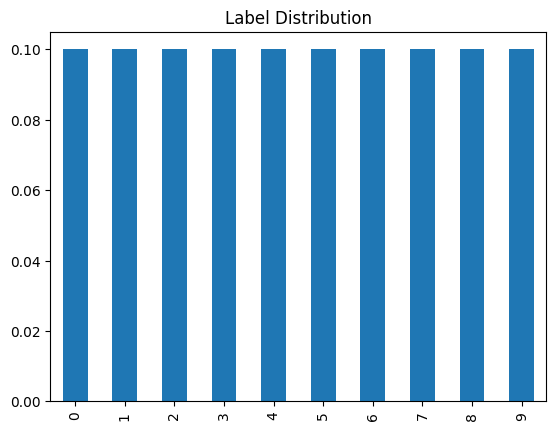

In [18]:
# Check label distribution
pd.Series(y_seq).value_counts(normalize=True).plot(kind='bar')
plt.title("Label Distribution")
plt.show()

## Split dataset

In [19]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

## Build Neural Network Model

In [20]:
# Build Neural Network Model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_seq)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Callbacks (use .h5 to avoid errors)
now = datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = f"best_model_{now}.h5"
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

## Train Model

In [22]:
# Train Model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/50
248/250 [============================>.] - ETA: 0s - loss: 1.5638 - accuracy: 0.3771
Epoch 1: val_accuracy improved from -inf to 0.54112, saving model to best_model_20250407-092603.h5
250/250 [==============================] - 9s 14ms/step - loss: 1.5624 - accuracy: 0.3774 - val_loss: 1.1459 - val_accuracy: 0.5411 - lr: 0.0010
Epoch 2/50
 14/250 [>.............................] - ETA: 1s - loss: 1.0896 - accuracy: 0.5625

c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - ETA: 0s - loss: 1.0353 - accuracy: 0.5843
Epoch 2: val_accuracy improved from 0.54112 to 0.63139, saving model to best_model_20250407-092603.h5
250/250 [==============================] - 2s 9ms/step - loss: 1.0353 - accuracy: 0.5843 - val_loss: 0.8841 - val_accuracy: 0.6314 - lr: 0.0010
Epoch 3/50
248/250 [============================>.] - ETA: 0s - loss: 0.9204 - accuracy: 0.6218
Epoch 3: val_accuracy improved from 0.63139 to 0.65145, saving model to best_model_20250407-092603.h5
250/250 [==============================] - 2s 9ms/step - loss: 0.9198 - accuracy: 0.6219 - val_loss: 0.8379 - val_accuracy: 0.6515 - lr: 0.0010
Epoch 4/50
246/250 [============================>.] - ETA: 0s - loss: 0.8720 - accuracy: 0.6428
Epoch 4: val_accuracy did not improve from 0.65145
250/250 [==============================] - 2s 9ms/step - loss: 0.8735 - accuracy: 0.6423 - val_loss: 0.8435 - val_accuracy: 0.6489 - lr: 0.0010
Epoch 5/50
247/250 [================

## Evaluate Model

In [23]:
# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6936


## Classification Report

In [24]:
# Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

63/63 [==============================] - 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           A       0.67      0.49      0.56       199
         MYL       0.53      0.60      0.56       199
        NFLX       0.93      0.96      0.95       199
         NFX       0.42      0.20      0.28       200
          NI       0.66      0.76      0.71       200
         NKE       0.74      0.78      0.76       199
        NLSN       0.55      0.76      0.64       200
         NOC       1.00      1.00      1.00       199
         NOV       0.58      0.57      0.58       199
         NRG       0.77      0.81      0.79       200

    accuracy                           0.69      1994
   macro avg       0.69      0.69      0.68      1994
weighted avg       0.69      0.69      0.68      1994



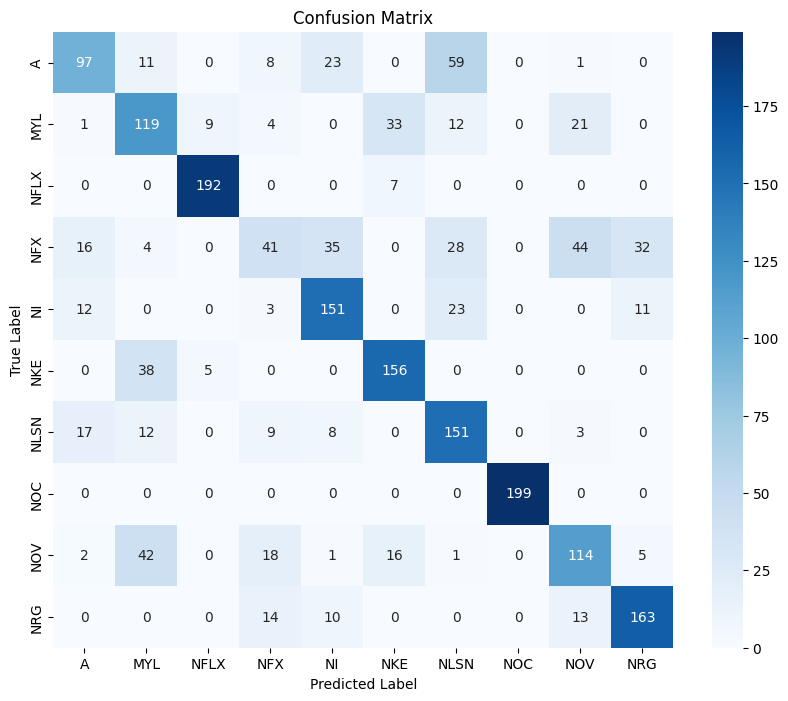

In [25]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Plot Training History

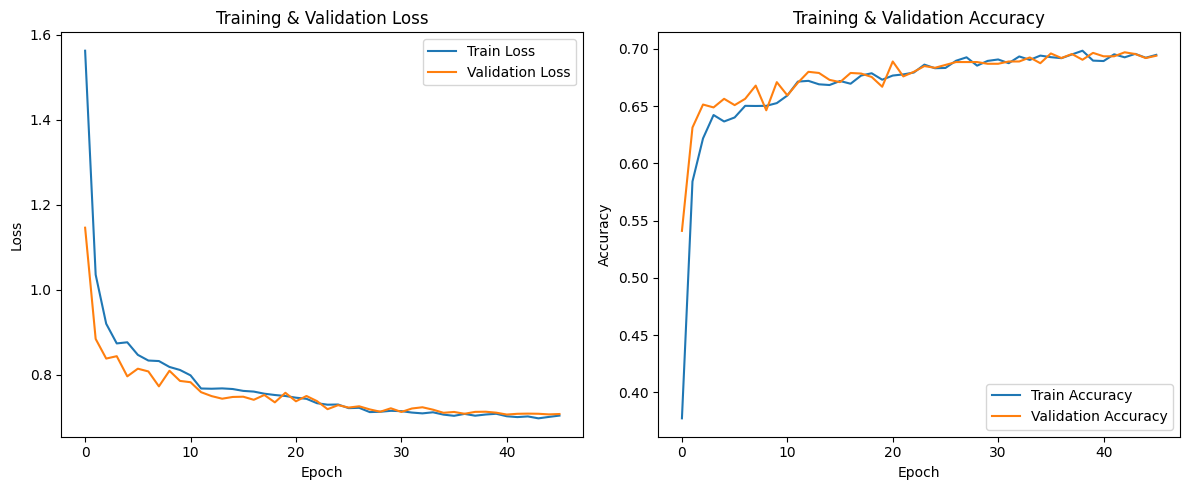

In [26]:
# Plot Training History
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()